<a href="https://colab.research.google.com/github/BaishaliChetia/CapsNet-Keras/blob/master/c_mnistTf2Normalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original implementation at:

https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb

Geron's model doesn't use the keras functional API. In the keras functional API, you don't need to give the batchsize. 

When you print the model, you get this:

```
Layer (type)                 Output Shape              Param #   
_________________________________________________________________
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 20, 20, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 1, 1152, 8)        0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 1, 1152, 8)        0         
_________________________________________________________________
Total params: 5,329,664
Trainable params: 5,329,664
Non-trainable params: 0
```

Notice that the Input-layer has shape (None, 28, 28, 1), but we only specified (28, 28, 1). It added None implicitly and that takes care of the batch.

So for anywhere Geron uses the batch size explicitly, you don't need to do anything and tensorflow will take care of.

Also note that tensorflow 1 APIs are still provided with the compat layer. I used the reduce_sum from TF1 in the squash layer, that allowed me to use Geron's code.

Documentation on how to migrate from TF1 to TF2 can be found here:

https://www.tensorflow.org/guide/migrate


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
import tensorflow.keras as K

In [3]:
caps1_n_maps = 32
caps1_n_caps = caps1_n_maps * 6 * 6  # 1152 primary capsules
caps1_n_dims = 8
caps2_n_caps = 10
caps2_n_dims = 16

tf.random.set_seed(500000)

In [4]:
class SquashLayer(K.layers.Layer):
  def __init__(self, axis=-1, **kwargs):
    super(SquashLayer, self).__init__(**kwargs)
    self.axis = axis
    
  def build(self, input_shapes):
    pass

  def call(self, inputs):
    EPSILON = 1.0e-9
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector


In [8]:
class SafeNorm(K.layers.Layer):
  
  def __init__(self, axis=-1, keep_dims = False,  **kwargs):
    super(SafeNorm, self).__init__(**kwargs)
    self.axis = axis
    self.keep_dims = keep_dims

  def build(self, input_shapes):
    pass

  def call(self, input):
    EPSILON = 1.0e-9
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           axis=self.axis,\
                                           keepdims= self.keep_dims)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    return safe_norm



In [7]:
# This should be the part where the digit layer, and where we tile things
# This is incomplete, and work in progress
# TODO: Complete this
class MyDigitCapsLayer(K.layers.Layer):
  def __init__(self, **kwargs):
    super(MyDigitCapsLayer, self).__init__(**kwargs)

  def build(self, input_shapes):
    init_sigma = 0.1  # TODO: use
    self.kernel = self.add_weight(\
                      "kernel",\
                      (caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),\
                      initializer="random_normal",\
                      dtype=tf.float32)

  
  # To debug this function, I used prints to print the shape
  # expand_dims just adds an exis, so if you say expand_dims(inshape=(5, 3), -1),
  # you get the output shape (5, 3, 1), it just adds an axis at the end
  # Then tile just multiplies one of the dimensions (that is it stacks along that direction N times)
  # so tile(inshape=(5, 3, 1), [1, 1, 1000]) will yield a shape (5, 3, 1000)
  #
  # Notice I didn't tile in build, but in call, Most probaly this is the right thing to do
  # but we'll only figure out when we actually train
  def call(self, inputs):
    # Add a dimension at the end
    exp1 = tf.expand_dims(inputs, -1, name="caps1_output_expanded")
    # add a dimension along 3rd axis
    exp1 = tf.expand_dims(exp1, 2, name="caps2_output_espanced")
    # tile along 3rd axis
    tile = tf.tile(exp1, [1, 1, caps2_n_caps, 1, 1], name="caps1_output_tiled")
    caps2_predicted = tf.matmul(self.kernel, tile, name="caps2_predicted")
    return caps2_predicted

In [9]:
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss
class MarginLoss(K.losses.Loss):
    def __init__(self, **kwargs):
      super(MarginLoss, self).__init__(**kwargs)
    
    def safe_norm(self, input, axis=-2, epsilon=1e-7, keep_dims=False, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

    

    def call(self,y_true, input):
      # print(f"y_true.shape = {y_true.shape}, y_pred.shape = {y_pred.shape}")
      # return K.losses.MeanSquaredError()(y_true, y_pred)

      #y_true = K.Input(shape=[], dtype=tf.int64, name="y")
      m_plus = 0.9
      m_minus = 0.1
      lambda_ = 0.5 
      
      #y_true one hot encode y_train
      T = tf.one_hot(y_true, depth=caps2_n_caps, name="T")
      
      caps2_output_norm = self.safe_norm(input, keep_dims = True)

      present_error_raw = tf.square(\
                                    tf.maximum(0., m_plus - caps2_output_norm),
                                    name="present_error_raw")
      present_error = tf.reshape(\
                                    present_error_raw, shape=(-1, 10),
                                    name="present_error")  
  
      absent_error_raw = tf.square(\
                                    tf.maximum(0., caps2_output_norm - m_minus),
                                    name="absent_error_raw")
      absent_error = tf.reshape(\
                                    absent_error_raw, shape=(-1, 10),
                                    name="absent_error")
  
      L = tf.add(\
                  T * present_error,\
                  lambda_ * (1.0 - T) * absent_error,
                  name="L")
      marginLoss = tf.reduce_mean(\
                                  tf.reduce_sum(L, axis=1),\
                                  name="margin_loss")
      return marginLoss



In [10]:
class RoutingByAgreement(K.layers.Layer):
  def __init__(self, roundno=-1, **kwargs):
    super(RoutingByAgreement, self).__init__(**kwargs)
    self.round_number = roundno

  def build(self, input_shapes):
    self.raw_weights_1 = self.add_weight("raw_weights", \
                                         (caps1_n_caps, caps2_n_caps, 1, 1), \
                                         initializer = "zeros", \
                                         dtype=tf.float32,)
    
    #print("Routing layer: self.raw_weights = ", self.raw_weights.shape, "input_shape = ", input_shapes)


  @staticmethod
  def squash(inputs):
    EPSILON = 1.0e-7
    squared_norm = tf.compat.v1.reduce_sum(tf.square(inputs),\
                                           keepdims=True)
    safe_norm = tf.sqrt(squared_norm + EPSILON)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = inputs / safe_norm
    return squash_factor * unit_vector

  def single_round_routing(self, inputs, raw_weights, agreement):
    raw_weights = tf.add(raw_weights, agreement)
    routing_wt = tf.nn.softmax(raw_weights, axis=2)
    wt_predictions = tf.multiply(routing_wt, inputs)
    wt_sum = tf.reduce_sum(wt_predictions, axis=1, keepdims=True)
    return wt_sum

  def call(self, inputs):
    agreement = tf.zeros(shape=self.raw_weights_1.shape)
    sqsh_wt_sum = None
    x = inputs
    for i in range(2):
      wt_sum = self.single_round_routing(inputs, self.raw_weights_1, agreement)
      sqsh_wt_sum = RoutingByAgreement.squash(wt_sum)
      sqsh_wt_sum_tiled = tf.tile(\
                          sqsh_wt_sum ,\
                          [1, caps1_n_caps, 1, 1, 1],\
                          name="caps2_output_round_1_tiled")
      agreement = tf.matmul(\
                            x, \
                            sqsh_wt_sum_tiled,\
                            transpose_a=True,\
                            name="agreement")
    return sqsh_wt_sum                           


In [11]:
(x_train, y_train,), (x_test, y_test) = K.datasets.mnist.load_data()
print(x_train.shape, x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


In [12]:
x_train = x_train/255.0
x_test = x_test/255.0

#print(x_train[500])

In [13]:
class Model:
    @staticmethod
    def build(inshape=(28, 28, 1)):
        inp = K.Input(shape=inshape, dtype=tf.float32, name='input')
        
        # Primary capsules
        # For each digit in the batch
        # 32 maps, each 6x6 grid of 8 dimensional vectors
        
        # First Conv layer
        conv1_params = \
        {
            "filters": 256,
            "kernel_size": 9,
            "strides": 1,
            "padding": "valid",
            "activation": tf.nn.relu,
        }
        x = K.layers.Conv2D(**conv1_params, name="conv_layer_1")(inp)
        
        # Second conv layer
        conv2_params = \
        {
            "filters": caps1_n_maps * caps1_n_dims, # 256 convolutional filters
            "kernel_size": 9,
            "strides": 2,
            "padding": "valid",
            "activation": tf.nn.relu
        }
        x = K.layers.Conv2D(**conv2_params, name="conv_layer_2")(x)
        
        # Reshape
        x = K.layers.Reshape(\
                             (caps1_n_caps, caps1_n_dims),\
                             name="reshape_layer_1")(x)
                             
        x = SquashLayer(name="caps1_output_layer")(x)
        
        x = MyDigitCapsLayer(name = "caps2_predicted")(x)
        caps2_predicted = x # Save this value for later
        
        #routing by agreement (2 rounds)
        x = RoutingByAgreement(name="routing1", roundno=2)(x)
        
        return K.Model(inputs=inp, outputs=x, name='my')
    
m = Model.build()
print(m.summary())


Model: "my"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 20, 20, 256)       20992     
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 6, 6, 256)         5308672   
_________________________________________________________________
reshape_layer_1 (Reshape)    (None, 1152, 8)           0         
_________________________________________________________________
caps1_output_layer (SquashLa (None, 1152, 8)           0         
_________________________________________________________________
caps2_predicted (MyDigitCaps (None, 1152, 10, 16, 1)   1474560   
_________________________________________________________________
routing1 (RoutingByAgreement (None, 1, 10, 16, 1)      11520    

In [14]:
y_train_train = tf.one_hot(y_train, depth=caps2_n_caps, name="T")
print(y_train_train.shape)
#print(y_train)

(60000, 10)


In [15]:
class MyAccuracy(K.metrics.Metric):
  def __init__(self, **kwargs):
    super(MyAccuracy, self).__init__(**kwargs)
    self.acc_obj = K.metrics.Accuracy()
    self.state = 0
  
  def safe_norm(self, input, axis=-2, epsilon=1e-7, keep_dims=True, name=None):
      squared_norm = tf.reduce_sum(tf.square(input), axis=axis,
                                     keepdims=keep_dims)
      return tf.sqrt(squared_norm + epsilon)

  def update_state(self, y_true, input, sample_weight=None):
    y_proba = self.safe_norm(input, axis=-2)
    y_proba_argmax = tf.argmax(y_proba, axis=2)
    y_pred = tf.squeeze(y_proba_argmax, axis=[1,2], name="y_pred")
    y_true = tf.reshape(y_true, (y_true.shape[0], ))
    y_true = tf.cast(y_true, dtype=tf.int64)
    self.acc_obj.update_state(y_true, y_pred, sample_weight)

  def reset_state(self):
    self.acc_obj.reset_state()

  def result(self):
    return self.acc_obj.result()

In [16]:
from keras.callbacks import ModelCheckpoint, CSVLogger
comparison_metric = MyAccuracy()
#checkpoint_filepath = "/content/drive/MyDrive/Weights/weights-improvement-{epoch:02d}-{val_my_accuracy:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/WeightsMnist/best_weights1.hdf5",
        save_weights_only=True,
        monitor=f"val_{comparison_metric.name}",
        mode='max',
        save_best_only=True)
model_checkpoint_callback2 = tf.keras.callbacks.ModelCheckpoint(
        filepath = "/content/drive/MyDrive/WeightsMnist/latest_weights1.hdf5",
        save_weights_only=True,
        monitor=f"val_{comparison_metric.name}",
        mode='max',
        save_best_only=False)
log_csv = CSVLogger("/content/drive/MyDrive/WeightsMnist/mylogs1.csv", separator = ",", append = False)
callback_list = [model_checkpoint_callback, model_checkpoint_callback2, log_csv]

In [17]:
m.compile(optimizer='adam', loss=MarginLoss(), metrics=[MyAccuracy()])
history = m.fit(x_train, y_train, batch_size=32, epochs=70, verbose= 1, validation_split=0.2, callbacks = callback_list)


Epoch 1/70
1500/1500 [==============================] - 143s 84ms/step - loss: 2.2814 - my_accuracy_1: 0.2138 - val_loss: 2.2802 - val_my_accuracy_1: 0.4701
Epoch 2/70
1500/1500 [==============================] - 124s 83ms/step - loss: 2.2799 - my_accuracy_1: 0.4685 - val_loss: 2.2803 - val_my_accuracy_1: 0.6529
Epoch 3/70
1500/1500 [==============================] - 113s 76ms/step - loss: 2.2795 - my_accuracy_1: 0.6034 - val_loss: 2.2795 - val_my_accuracy_1: 0.8618
Epoch 4/70
1500/1500 [==============================] - 124s 82ms/step - loss: 2.2793 - my_accuracy_1: 0.7100 - val_loss: 2.2793 - val_my_accuracy_1: 0.8745
Epoch 5/70
1500/1500 [==============================] - 113s 76ms/step - loss: 2.2791 - my_accuracy_1: 0.7406 - val_loss: 2.2799 - val_my_accuracy_1: 0.7988
Epoch 6/70
1500/1500 [==============================] - 123s 82ms/step - loss: 2.2792 - my_accuracy_1: 0.7943 - val_loss: 2.2796 - val_my_accuracy_1: 0.7689
Epoch 7/70
1500/1500 [==============================] - 12

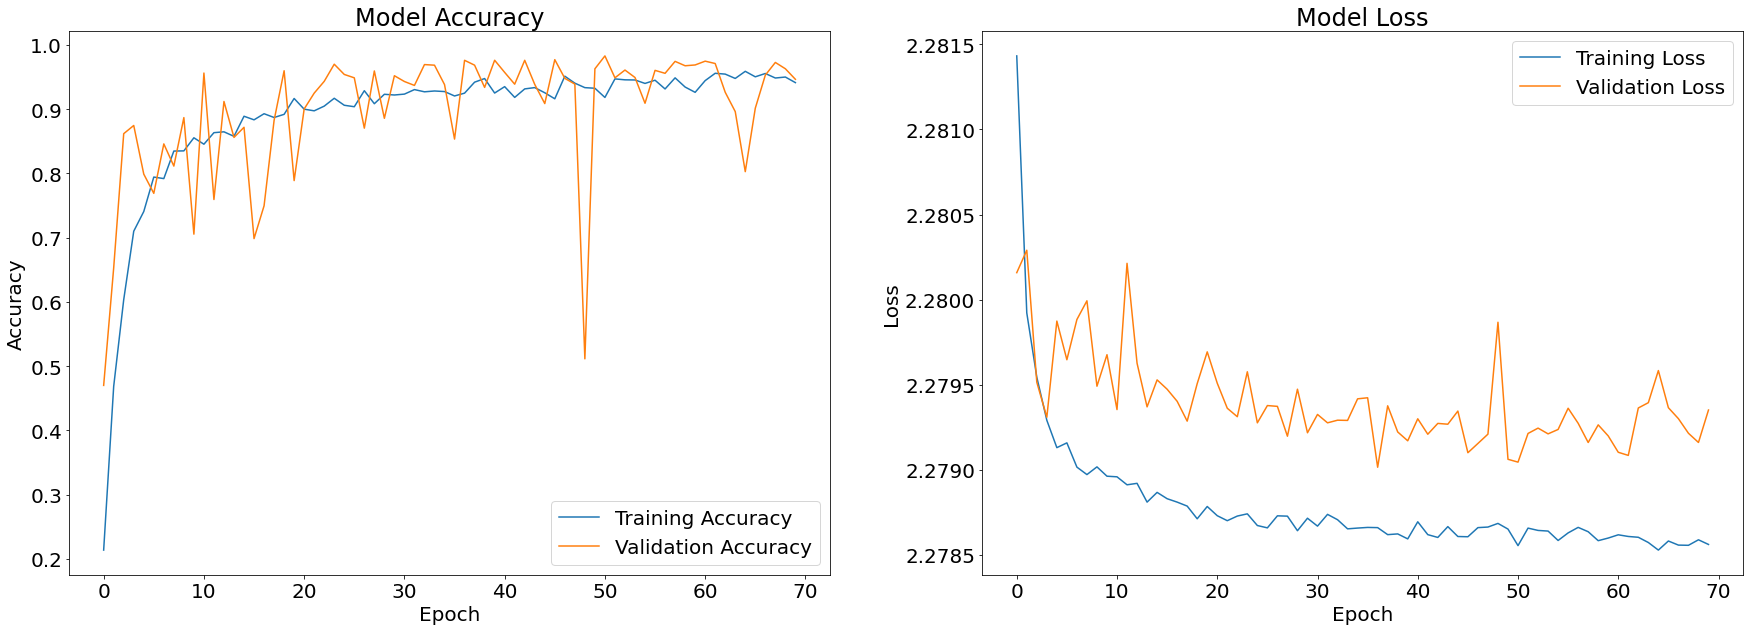

In [19]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams["font.size"] = 20

fig, ax = plt.subplots(1, 2)

ax[0].plot(history.history['my_accuracy_1'])
ax[0].plot(history.history['val_my_accuracy_1'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Training Loss', 'Validation Loss'], loc='best')
plt.show()


In [21]:
print(f'Best Validation Accuracy = {np.max(history.history["val_my_accuracy_1"])}')
print(f'Best Training   Accuracy = {np.max(history.history["my_accuracy_1"])}')

Best Validation Accuracy = 0.9827499985694885
Best Training   Accuracy = 0.9587708115577698
